# DNN with Word-based Tokenization

In [1]:
import io
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

## Load data from JSON (reminder)

In [2]:
# Download the dataset
# https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

# Read data from JSON
'''
import json

# Load the JSON file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_size = 20000

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]
'''

'\nimport json\n\n# Load the JSON file\nwith open("./sarcasm.json", \'r\') as f:\n    datastore = json.load(f)\n\n# Initialize the lists\nsentences = []\nlabels = []\n\n# Collect sentences and labels into the lists\nfor item in datastore:\n    sentences.append(item[\'headline\'])\n    labels.append(item[\'is_sarcastic\'])\n'

## Parse data from CSV

Download Data Set:
https://www.kaggle.com/competitions/learn-ai-bbc/data
https://drive.google.com/file/d/1G2oRS3o_dnTOpmPEbi8MEk9dO0NWyz0d/view?usp=sharing

In [3]:
with open("./bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n{csvfile.readline()}")

First line (header) looks like this:
category,text

Each data point looks like this:
tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  

### Removing Stopwords

One important step when working with text data is to remove the stopwords from it. These are the most common words in the language and they rarely provide useful information for the classification process.

In [4]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords
    Args:
        sentence (string): sentence to remove the stopwords from
    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords =  ["to", "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    # Sentence converted to lowercase-only
    sentence = sentence.lower()
    words = sentence.split()
    sentence = " ".join([w for w in words if w not in stopwords])

    return sentence

In [5]:
remove_stopwords("I am about to go to the store and get any snack")

'go store get snack'

In [6]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    Args:
        filename (string): path to the CSV file
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter= ',')
        next(reader)
        for row in reader:
            sentences.append(remove_stopwords(row[1]))
            labels.append(row[0])
    return sentences, labels

In [7]:
sentences, labels = parse_data_from_file("./bbc-text.csv")

print(f"There are {len(sentences)} sentences in the dataset.")
print(f"Largest sentence has {max([len(sentence.split()) for sentence in sentences])} words (after removing stopwords).")
print(f"There are {len(labels)} labels in the dataset.")
print(f"The first 5 labels are {labels[:5]}")

There are 2225 sentences in the dataset.
Largest sentence has 4390 words (after removing stopwords).
There are 2225 labels in the dataset.
The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


## Global Variables

- `NUM_WORDS`: The maximum number of words to keep, based on word frequency.
- `EMBEDDING_DIM`: Dimension of the dense embedding.
- `MAXLEN`: Maximum length of all sequences.
- `PADDING`: Padding strategy.
- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls.
- `TRAINING_SPLIT`: Proportion of data used for training.

In [8]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

## Training - Validation Split

In [9]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets
    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set
    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [10]:
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} labels and sentences for validation." if len(train_sentences) == len(train_labels) else "Labels and sentences length must be equal")
print(f"There are {len(val_sentences)} labels and sentences for validation." if len(val_sentences) == len(val_labels) else "Labels and sentences length must be equal")

There are 1780 labels and sentences for validation.
There are 445 labels and sentences for validation.


## Tokenization Sequences

In [11]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class on the training sentences
    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [12]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 27294 words
<OOV> token included in vocabulary


## Padding Sequences

In [13]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length
    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Pad the sequences using the correct padding and maxlen
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)

    return padded_sequences

In [14]:
train_padded_sequence = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_sequence = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)
print(f"First padded sequence looks like this: {train_padded_sequence[0]}")
print(f"Numpy array of all sequences has shape: {train_padded_sequence.shape}")

First padded sequence looks like this: [207 664   4 347   1   1  39 971 745  27   2 115  11   1   8   1   1   1
 151  19  43   1   1   1   1   5 670   1  39   4   2  37   8 312   1 151
 199   1  23 158 745 912   1   1  27   2 115  19 610 762   4   1   1   1
   1   5   6 573   1   2  89  40   1   5   1 151  10   3   1 762   5 348
 181 317   1 436   7 733 115   1 848   6   1  19   1 214   1  52 484  32
  40 130   1   1  14 859   1   5 183 676 669   1   2   1   1   4   1  57
   1 155  12  32  40 984 157  38 136 152  38 136]
Numpy array of all sequences has shape: (1780, 120)


## Tokenization Labels

In [15]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels
    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize
    Returns:
        label_seq_np (array of int): tokenized labels
    """
    # Instantiate the Tokenizer class
    label_tokenizer = Tokenizer()

    # Fit the tokenizer to the labels
    label_tokenizer.fit_on_texts(all_labels)

    # Save the word index
    label_word_index = label_tokenizer.word_index

    # Convert labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)
    # print(label_seq[:5])

    # Convert sequences to a numpy array (Keras expects np.array labels starting at 0, [0, 1, 2, 3, 4] not [1, 2, 3, 4, 5] as they are)
    label_seq_np = np.array(label_seq) - 1

    return label_seq_np, label_word_index

In [16]:
train_label_sequence, label_word_index = tokenize_labels(labels, train_labels)
val_label_sequence, label_word_index = tokenize_labels(labels, val_labels)
print(f"Vocabulary of labels looks like this: {label_word_index}")
print(f"First 5 sequences: \n{train_label_sequence[:5]}")

Vocabulary of labels looks like this: {'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}
First 5 sequences: 
[[3]
 [1]
 [0]
 [0]
 [4]]


## Model

In [17]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model
    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences
    Returns:
        model (tf.keras Model): the text classifier model
    """

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.GlobalAveragePooling1D(), # Max value across the time dimension
        tf.keras.layers.Dense(embedding_dim, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [18]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
model.summary()

history = model.fit(train_padded_sequence, train_label_sequence, epochs=30, validation_data=(val_padded_sequence, val_label_sequence))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 5)                 85        
                                                                 
Total params: 16,357
Trainable params: 16,357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
56/56 [==============================] - 1s 7ms/step - loss: 1.6030 - accuracy: 0.2303 - val_loss: 1.5960 -

## Accuracy and Loss

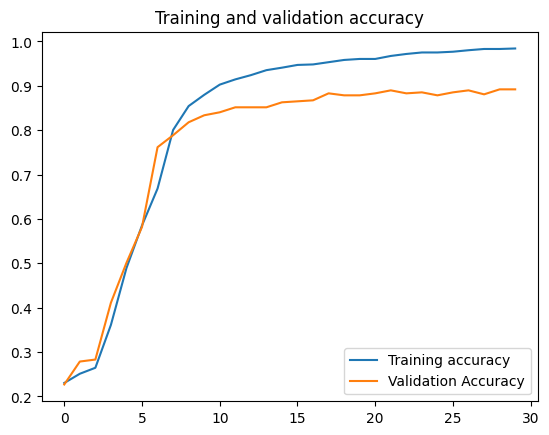

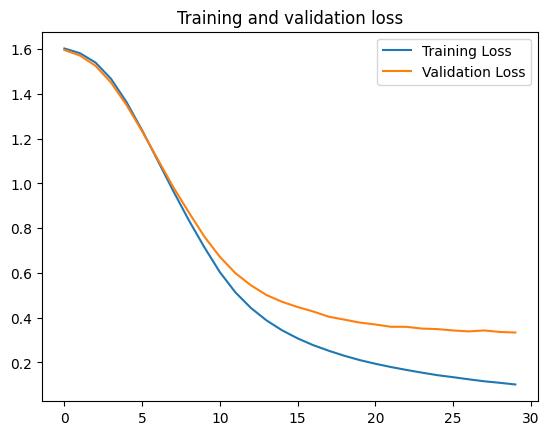

In [19]:
def plot_acc_val(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss' ]
    epochs = range(len(acc)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_acc_val(history)

## Visualizing 3D Vectors

https://projector.tensorflow.org/

In [20]:
# Reverse word index
reverse_word_index = tokenizer.index_word
# reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Save the embedding layer
e = model.layers[0]

# Save the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


In [21]:
# Generate files for embedding visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()